# Система метрик Mines&Moles

## Описание проекта

Заказчик - игра Mines & Moles. Это однопользовательская мобильная игра в жанре rogue-like. Цель игры — прохождение уровней, каждый из которых представляет собой сложную систему подземных шахт.  

Алгоритм игры генерирует наполнение уровней случайным образом. Задача игрока — избежать опасностей (ловушек и монстров) и собрать ценные предметы, например оружие и золото. 

Создатели игры заинтересованы в том, чтобы пользователи не застревали на уровнях и не начинали их заново по многу раз. Это вызывает у игроков раздражение и приводит к оттоку аудитории. 
Маркетинговые исследования показали, что большинство пользователей начинают «залипать» в игру и делать покупки в магазине после прохождения 10 уровней. 

## Описание данных 

**Данные лежат в схеме `mines`:**


**Данные пользователей — таблица `users`**
- `device_id` — идентификатор устройства пользователя, на которое установлена игра (type: String);
- `user_id` — идентификатор зарегистрированного в игре пользователя, NULL — если пользователь не зарегистрирован (type: Int);
- `install_time` — дата и время установки приложения (type: DateTime);
- `country_code` — код страны пользователя (определяется по магазину приложений, в котором была скачана игра) (type: String);
- `platform` — операционная система устройства, на которое установлена игра (iOS или Android) (type: String);
- `traffic_type` — тип источника привлечения пользователя (органический, платный, реферальный) (type: String);
- `source` — конкретный источник привлечения пользователя (type: String);
- `campaign` — идентификатор рекламной кампании (только для платного трафика, для остальных — NULL) (type: String).

**Данные о событиях — таблица `events`**
- `device_id` — уникальный идентификатор устройства пользователя (type: String);
- `session_id` — идентификатор сессии пользователя (type: Int);
- `time` — дата и время события (type: DateTime);
- `event_name` — название события (type: String), список событий:
- `app_start` — старт приложения;
- `registration_complete` — прохождение регистрации;
- `game_launched` — запуск игры;
- `store_open` — открытие магазина;
- `item_add_to_cart` — добавление предмета в корзину;
- `checkout_load` — открытие чекаута;
- `order_completed` — завершение заказа.

**Данные о прохождении уровней — таблица `game_sessions`**
- `device_id` — уникальный идентификатор устройства пользователя (type: String);
- `session_id` — идентификатор сессии пользователя (type: Int);
- `level_id` — идентификатор уровня (type: Int);
- `time_start` — дата и время начала прохождения уровня (type: DateTime);
- `time_end` — дата и время окончания прохождения уровня (type: DateTime);
- `success_fact` — завершение уровня пользователем: 1 — завершён, 0 — не завершён (type: Int);
- `duration_sec` — длительность прохождения уровня в секундах (type: Int).

**Данные о транзакциях в игровом магазине — таблица `transactions`**
- `device_id` — уникальный идентификатор устройства пользователя (type: String);
- `session_id` — идентификатор сессии пользователя (type: Int);
- `transaction_id` — идентификатор транзакции (type: Int);
- `time` — дата и время транзакции (type: DateTime);
- `payment_type` — способ оплаты (банковская карта, PayPal, внутриигровой кошелёк) (type: String);
- `item_name` — название товара в магазине (type: String);
- `price` — цена товара в долларах (type: Float);
- `status` — результат транзакции (success — оплата прошла успешно, failed — оплата не прошла) (type: String).

## Задача

В начале 2024 года продукт достаточно активно рос: увеличивалась активная аудитория и выручка внутриигрового магазина. Но с июля 2024 года менеджеры начали фиксировать сначала стагнацию, а затем и снижение выручки от месяца к месяцу.

Никаких технических проблем не фиксировалось, но летом произошли изменения в пользовательском опыте: редизайн внутриигрового магазина и корректировка алгоритма, который генерирует уровни.  
Менеджеры продукта обратились к аналитику, то есть к вам, чтобы определить, почему игра теряет деньги.

Задачи: 
- Найти причину проблемы: определить, в какой части продукта произошла поломка.
- Сформулировать выводы и презентовать их команде продукта.

Ниже будет представлено дерево метрик, с которыми будем работать.

![image.png](https://pictures.s3.yandex.net/resources/2.7.1_1_1741702625.png)


Гипотезы по дереву метрик:
- Ухудшилась стратегия привлечения новых пользователей.
- Опыт текущих пользователей в игре ухудшается.
- Пользователи стали покупать меньше товаров или более дешёвые товары.
- Пользователи стали менее активно совершать покупки.

## Выполнение поставленных задач

Заранее мы предобработали данные в SQL и создали общий датасет, с помощью которого мы будем решать бОльшую часть задач. Далее выгрузим его. 

In [1]:
# Выгрузим основной датасет и необходимые библиотеки

# Эта ячейка исправит проблему SSL если она есть
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

events = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_events.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_users.csv')
transactions = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_transactions.csv')

#game_sessions из условия
game_sessions = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_game_sessions.csv')

#новый датасет
df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_dataset.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61974 entries, 0 to 61973
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   device_id             61974 non-null  object
 1   first_activity_month  61974 non-null  object
 2   all_activity_month    61974 non-null  object
 3   platform              61974 non-null  object
 4   country_code          61974 non-null  object
 5   traffic_type          61974 non-null  object
dtypes: object(6)
memory usage: 2.8+ MB


В новом датасете 6 столбцов. Все они типа `object` и имеют 61974 строк: 
- `device_id` - идентификатор устройства пользователя, на которое установлена игра.
- `first_activity_month`- месяц первого запуска приложения пользователем в формате ГГГГ-ММ-ДД.
- `all_activity_month` - месяц всех запусков приложения пользователем в формате ГГГГ-ММ-ДД.
- `platform` - операционная система устройства, на которое установлена игра (iOS или Android)
- `country_code` - код страны пользователя (определяется по магазину приложений, в котором была скачана игра).
- `traffic_type` - тип источника привлечения пользователя (органический, платный, реферальный).



Далее прикрепим код, которы был запущен в учебной тренажере для преобразования датасета: 

1. Cоздаем CTE `first_event`, где мы определяем месяц первого запуска приложения пользователем. Активность пользователей и их возвращаемость в продукт считаем по событию запуска приложения (app_start), поэтому провели фильтрацию. Данные берем из таблицы `mines.events`.

2. Cоздаем CTE `all_events`, где мы определяем месяц всех запусков приложения пользователем. Данные берем из таблицы `mines.events`.

3. В итоговом запросе объединяем данные, полученные из первых двух шагов. 


WITH first_event AS (
      SELECT
         device_id,
         MIN(date_trunc('month', TIME)::date) AS first_activity_month
      FROM mines.events
      WHERE event_name = 'app_start'
      GROUP BY device_id
               ), 
               
               
   all_events AS (
      SELECT
         device_id,
         date_trunc('month', TIME) ::date AS all_activity_month
      FROM mines.events
      WHERE event_name = 'app_start'
      GROUP BY device_id, all_activity_month
               )
               
               
SELECT
   t1.device_id,
   t1.first_activity_month,
   t2.all_activity_month,
   platform,
   country_code,
   traffic_type
FROM first_event AS t1
   LEFT JOIN all_events AS t2
           ON t1.device_id = t2.device_id
   LEFT JOIN mines.users AS t3
           ON t1.device_id = t3.device_id

In [2]:
df.head(3)

,device_id,first_activity_month,all_activity_month,platform,country_code,traffic_type
0,000241fd-d220-413e-aeef-36c7bc9a4b22,2024-09-01,2024-09-01,ios,RU,organic
1,000241fd-d220-413e-aeef-36c7bc9a4b22,2024-09-01,2024-12-01,ios,RU,organic
2,000d2a74-9158-4ae4-8c3c-5d6afe4efee0,2024-10-01,2024-10-01,android,AM,referral


**Далее считаем метрики.**

Начнём с расчёта MAU.
Используя предобработанный датасет рассчитаем:
- Общий MAU по всем пользователям.
- MAU в разрезе платформ пользователей.


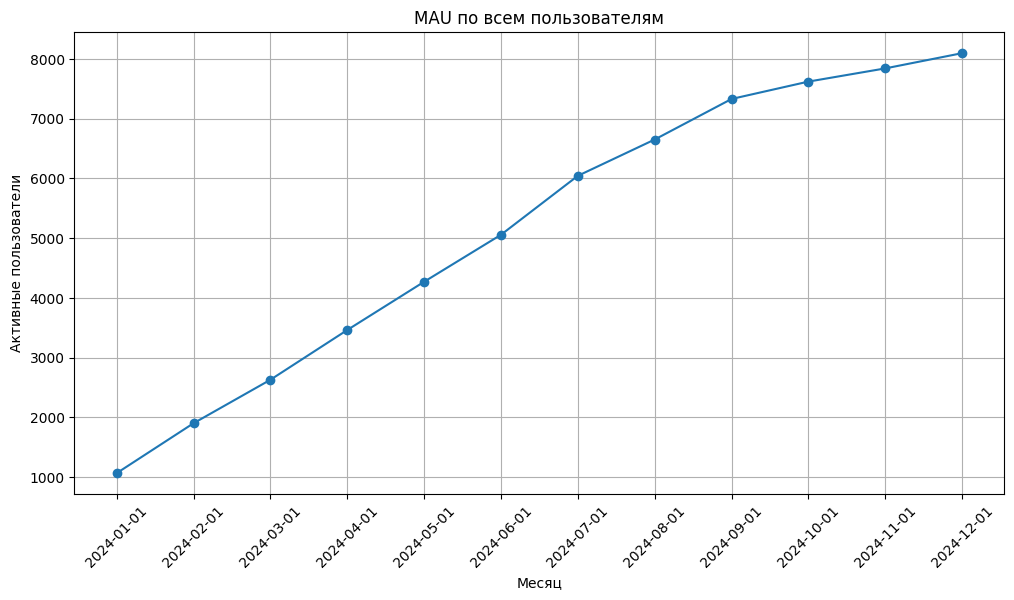

In [3]:
mau_all = df.groupby('all_activity_month')['device_id'].nunique().reset_index()

plt.figure(figsize=(12,6))
plt.plot(mau_all['all_activity_month'], mau_all['device_id'], marker = 'o')
plt.title('MAU по всем пользователям')
plt.xlabel('Месяц')
plt.ylabel('Активные пользователи')
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

**Интерпретация графика:**
Можно заметить, что график MAU имеет восходящий тренд с начала года и до конца, колебаний нет, общий MAU не влияет на снижение Выручки, так как количество активных пользователей росло. 


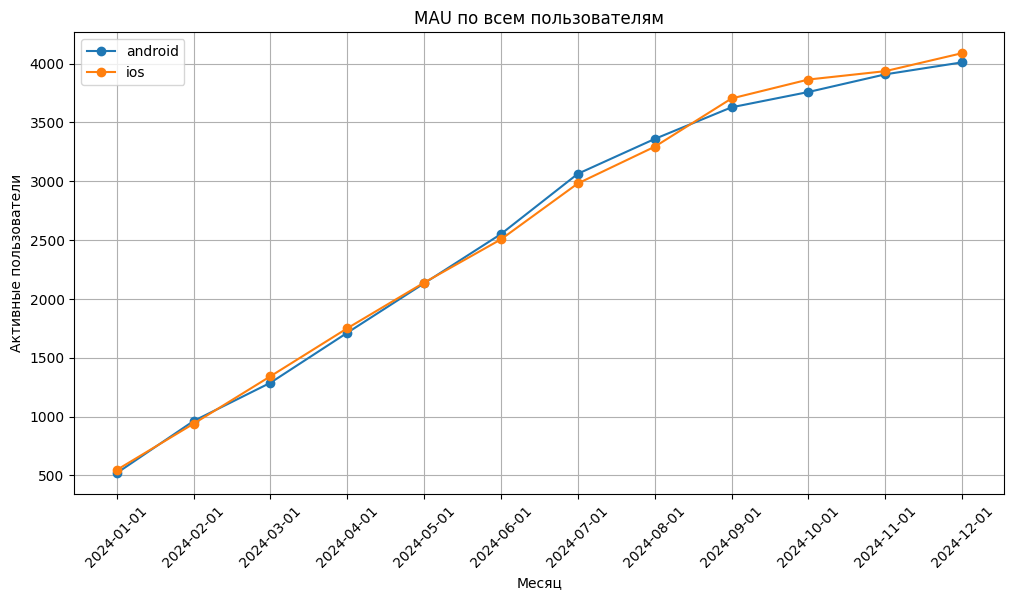

In [4]:
mau_platforms = df.groupby(['all_activity_month', 'platform'])['device_id'].nunique().reset_index()

plt.figure(figsize=(12,6))

for platform in mau_platforms['platform'].unique():
    plt.plot(mau_platforms[mau_platforms['platform']==platform]['all_activity_month'], mau_platforms[mau_platforms['platform']==platform]['device_id'], marker = 'o')
plt.title('MAU по всем пользователям')
plt.xlabel('Месяц')
plt.ylabel('Активные пользователи')
plt.xticks(rotation = 45)
plt.legend(['android', 'ios'])
plt.grid(True)
plt.show()

**Интерпретация графика:**
Можно заметить, что график MAU по платформам также имеет восходящий тренд с начала года и до конца, колебаний нет, MAU по платформам не влияет на снижение Выручки, так как количество активных пользователей росло на обеих платформах. Между платформами есть небольшие различия в количестве активных пользователей, но в пределах нормы, аномалий нет. 


Рассчитаем и визуализируем **количество новых пользователей по источникам привлечения**. Покажем динамику по месяцам. 

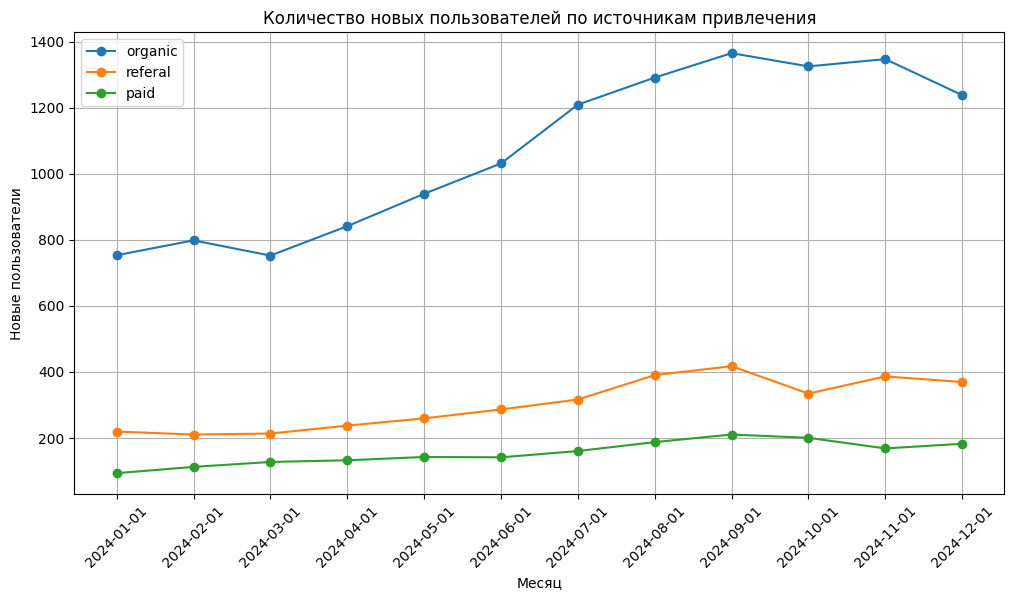

In [5]:
new_users = df.groupby(['first_activity_month', 'traffic_type'])['device_id'].nunique().reset_index()

plt.figure(figsize=(12,6))

for t in new_users['traffic_type'].unique():
    plt.plot(new_users[new_users['traffic_type'] == t]['first_activity_month'], new_users[new_users['traffic_type'] == t]['device_id'], marker = 'o')
plt.title('Количество новых пользователей по источникам привлечения')
plt.xlabel('Месяц')
plt.ylabel('Новые пользователи')
plt.legend(['organic', 'referal','paid'])
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

**Интерпретация графика:**
Можно заметить, что канал привлечения `organic` работает лучше остальных на протяжении всего года. Виден восходящий тренд. По каналу organic наибольшее количество новых пользователей пришло в 2024-09-01. Периодических колебаний нет. Наименьший приток новых пользователей по каналу было 2024-03-01. 

По каналам `referal` и `paid` приток новых пользователей по сравнению с organic намного меньше, наибольший приток пользователей также наблюдается в сентябре. Два данных графика стабильны, нет серьезных восхождений/спадов. 

Можно узнать, почему именно канал `organic` работает лучше, чем два остальных. Но на снижение Выручки не повлияло ухудшение стратегии привлечения новых пользователей.

Рассчитаем и визуализируем на тепловой карте **Retention Rate по когортам.** 

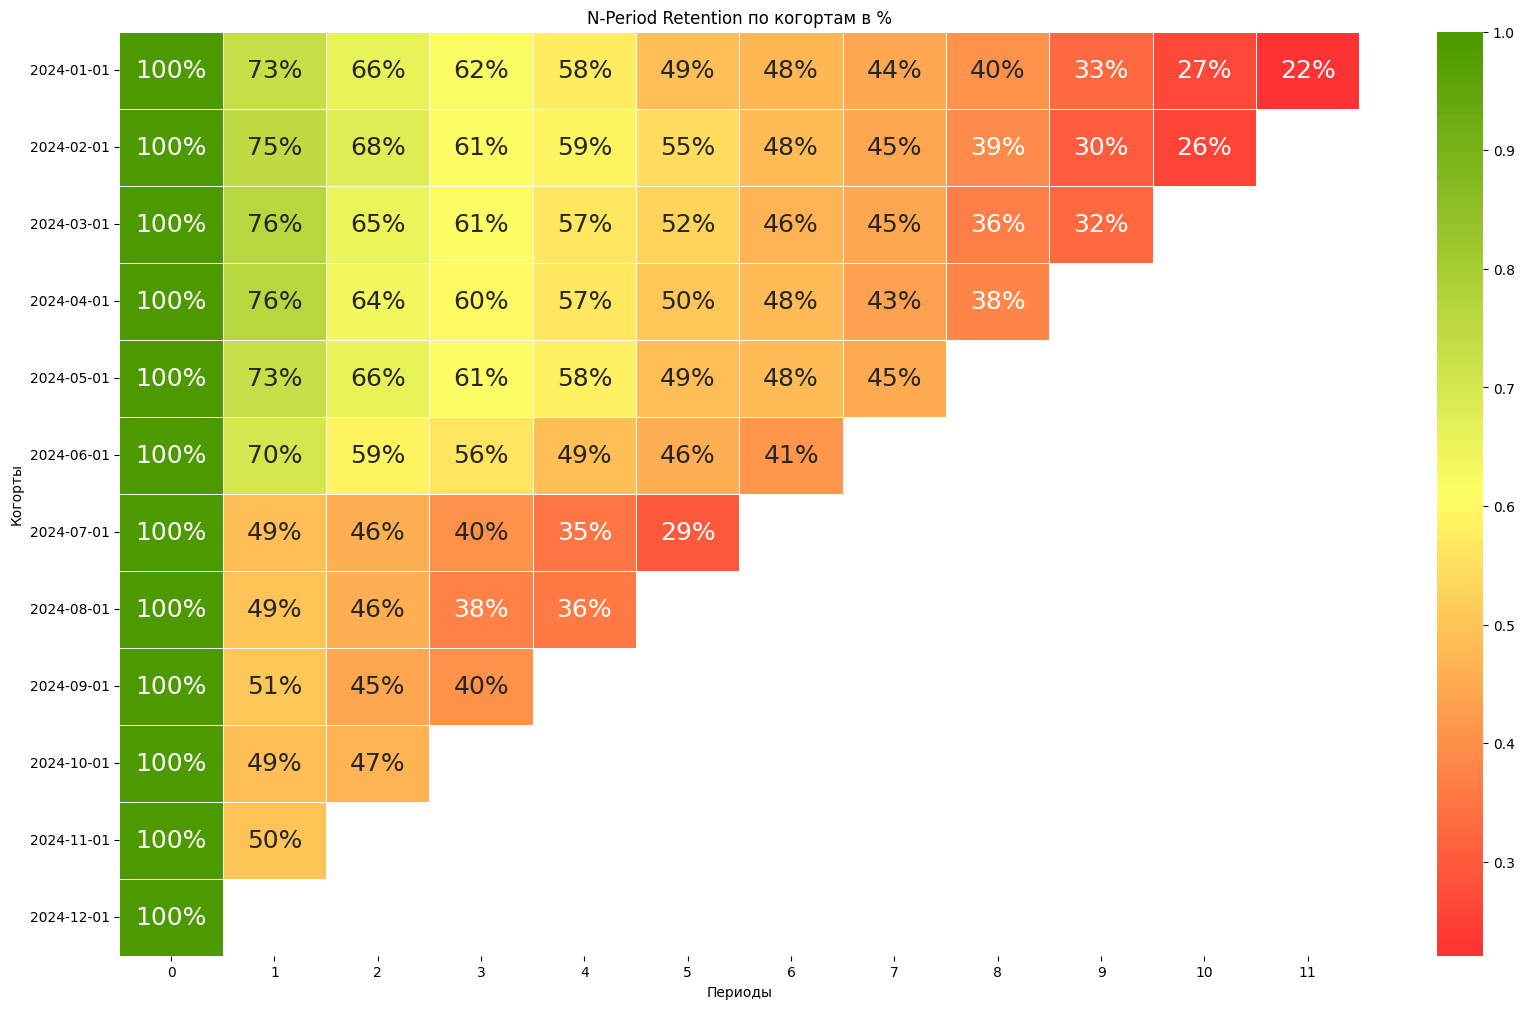

In [6]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)
df['all_activity_month'] = pd.to_datetime(df['all_activity_month'])
df['first_activity_month'] = pd.to_datetime(df['first_activity_month'])
df['n_period'] = (df['all_activity_month'].dt.to_period('M').astype('int64') - df['first_activity_month'].dt.to_period('M')
                 .astype('int64'))
df['first_activity_month'] = df['first_activity_month'].dt.date
data_pivot = pd.pivot_table(df,
                           values='device_id',
                           index='first_activity_month',
                           columns='n_period',
                           aggfunc=pd.Series.nunique)
data_pivot = data_pivot.div(data_pivot[0], axis=0)
plt.figure(figsize=(20, 12))
sns.heatmap(data_pivot,
           cmap=cmap,
           annot=True,
           fmt='.0%',
           linewidth=0.5,
           annot_kws={"size": 18})
plt.title('N-Period Retention по когортам в %')
plt.xlabel('Периоды')
plt.ylabel('Когорты')
plt.show()

**Интерпретация графика:**
Можно заметить, что сильное ухудшение RR начинается с 2024-07-01 (именно тогда менеджеры начали наблюдать стагнацию и дальнейшее снижение выручки). Скорее всего RR негативно повлиял на объемы выручки. 


Используя данные из таблицы `game_sessions`, выполним расчёт и визуализацию **средней доли пройденных уровней на сессию.** Покажем динамику по месяцам.

Для расчёта необходимо посчитать количество пройденных и запущенных уровней для каждой игровой сессии.
Сессия определяется уникальным сочетанием полей dt, device_id и session_id.
Формула метрики:

`Доля пройденных уровней на сессию = Количество пройденных уровней за сессию / Количество запущенных уровней за сессию`

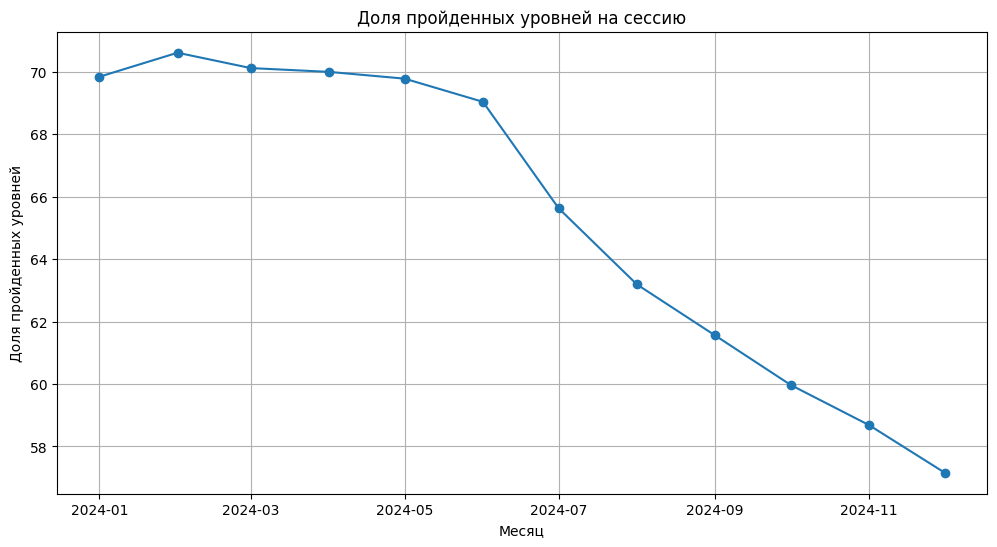

In [7]:
game_sessions['dt'] = pd.to_datetime(game_sessions['time_end']).dt.to_period('M').dt.to_timestamp()

# Явное указание функций агрегации
game_sessions_grouped = game_sessions.groupby(['dt','device_id', 'session_id']).agg(
    success=('success_fact', 'sum'),
    total=('success_fact', 'count')
).reset_index()

game_sessions_grouped['success_rate'] = 100 * (game_sessions_grouped['success'] / game_sessions_grouped['total'])
game_sessions_grouped = game_sessions_grouped.groupby('dt')['success_rate'].mean().reset_index()


plt.figure(figsize=(12,6))
plt.plot(game_sessions_grouped['dt'], game_sessions_grouped['success_rate'], marker = 'o')
plt.title('Доля пройденных уровней на сессию')
plt.xlabel('Месяц')
plt.ylabel('Доля пройденных уровней')
plt.grid(True)
plt.show()

**Интерпретация графика:**

Средняя доля пройденных уровней на сессию уменьшается на протяжении всего года, наблюдается нисходящий тренд, резко снижается с 2024-07-01. Именно доля пройденных уровней негативно сказалась на динамике RR, которую мы проверяли в прошлом пункте. Видимо, корректировка алгоритма, который генерирует новые уровни в игре работает неэффективно и вызывает снижение доли пройденных уровней. 



Выполним расчёт и визуализацию метрики **ARPAU** по месяцам.

Формула метрики: 
`ARPAU = Сумма стоимостей успешных покупок пользователей за период / Количество уникальных пользователей за период`


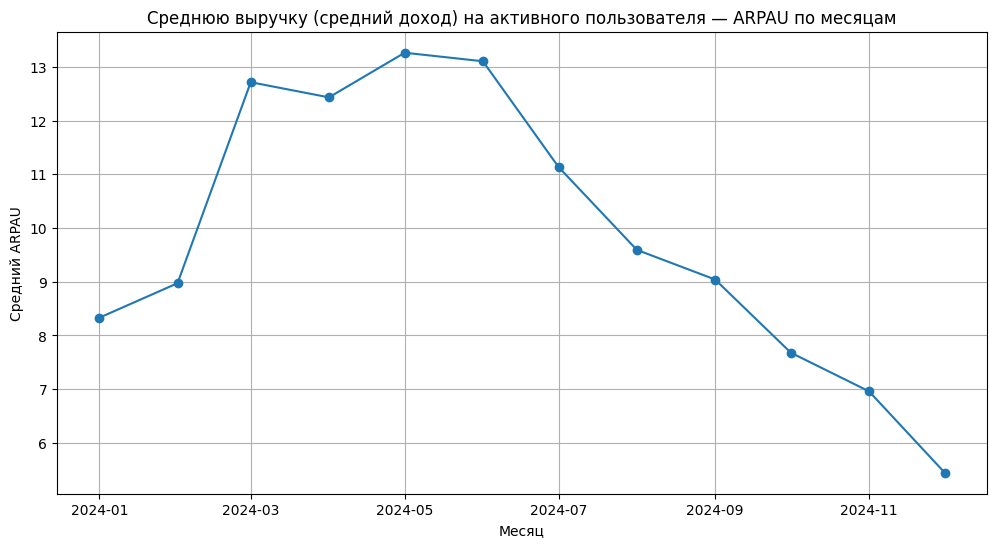

In [8]:
transactions['dt'] = pd.to_datetime(transactions['time']).dt.to_period('M').dt.to_timestamp()
events['dt'] = pd.to_datetime(events['time']).dt.to_period('M').dt.to_timestamp()

success_transactions = transactions[transactions['status']=='success']
transactions_sum = success_transactions.groupby(['device_id','dt'])['price'].sum().reset_index()

users_n = events.groupby('dt')['device_id'].nunique().reset_index()

merged_df = pd.merge(transactions_sum , users_n, how = 'left', on = 'dt')


merged_df = merged_df.groupby('dt').agg(price=('price', 'sum'),
                                        device_id=('device_id_y', 'min')).reset_index()


merged_df['ARPAU'] = merged_df['price']/merged_df['device_id']


plt.figure(figsize=(12,6))
plt.plot(merged_df['dt'], merged_df['ARPAU'], marker = 'o' )
plt.title('Среднюю выручку (средний доход) на активного пользователя — ARPAU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний ARPAU')
plt.grid(True)
plt.show()



**Интерпретация графика:**
По графику видно, что в начале года наблюдается увеличение средней выручки (среднего дохода) на активного пользователя, максимальное значение приходится на 2024-05, а с 2024-07 начинается резкий спад, который продолжается до конца года. Требуется изучить метрики нижнего уровня, чтобы понять, что конкретно вызвало спад средней выручки на активного пользователя, а впоследствии главной метрики -  Выручки. 

Выполним расчёт и визуализацию воронки конверсии в покупку.
События воронки от первого этапа до последнего: 
- `app_start` — запуск приложения (берём за 100% и в визуализацию не включаем);
- `store_open` — открытие магазина;
- `item_add_to_cart` — добавление предмета в корзину;
- `checkout_load` — открытие чекаута;
- `order_completed` — завершение заказа.
При расчёте используем окно атрибуции, равное 30 дням.

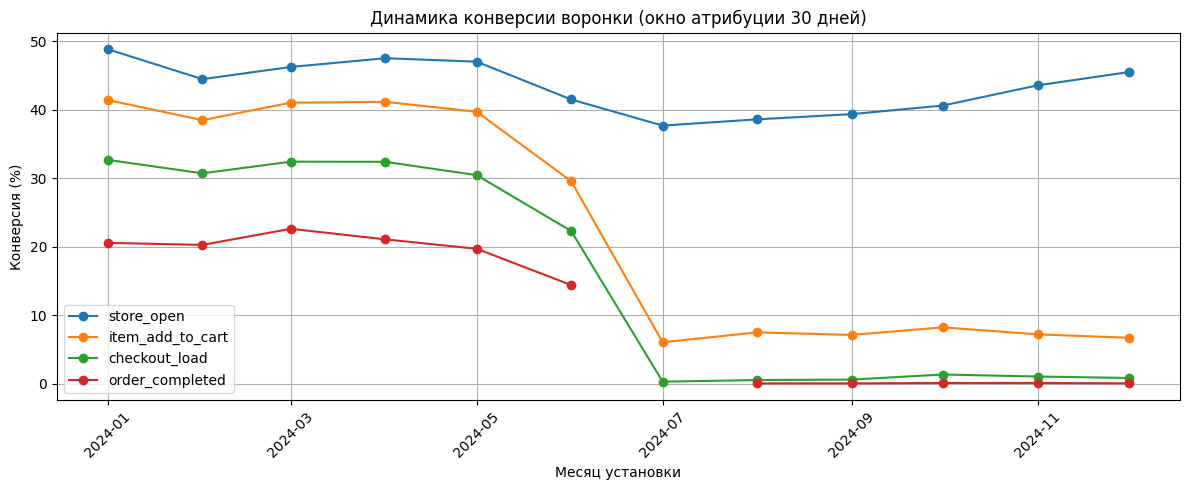

In [9]:
events['time'] = pd.to_datetime(events['time'])
users['install_time'] = pd.to_datetime(users['install_time'])

df = pd.merge(events, users[['device_id', 'install_time']], on='device_id', how='left')
attribution_window = 30
df['diff_days'] = (df['time'] - df['install_time']).dt.days
df['install_month'] = df['install_time'].dt.to_period('M').dt.to_timestamp()
df = df[df['diff_days'].between(0, attribution_window)]
event_list = ['store_open', 'item_add_to_cart', 'checkout_load', 'order_completed']
funnel_dynamic = df.groupby('install_month')['device_id'].nunique().reset_index(name='install_devices')
plt.figure(figsize=(12, 5))
for event in event_list:
    df_event = df[df['event_name'] == event]
    df_event = df_event.groupby('install_month')['device_id'].nunique().reset_index(name=event)
    funnel_dynamic = funnel_dynamic.merge(df_event, on='install_month', how='left')
    funnel_dynamic[event] = (funnel_dynamic[event] / funnel_dynamic['install_devices']) * 100
    plt.plot(funnel_dynamic['install_month'], funnel_dynamic[event], marker='o', label=event)
plt.title('Динамика конверсии воронки (окно атрибуции 30 дней)')
plt.xlabel('Месяц установки')
plt.ylabel('Конверсия (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Интерпретация графика:**
Заметим, что именно 2024-07 есть ухудшение в каждом шаге воронки, а на последнем шаге завершении заказа график вообще прерывается. Падение неравномерно. Очевидно, что эта метрика сказалась на Средней выручке на активного пользователя и на Выручку в целом. На эту метрику влияет Доля пользователей, у которых пройдено более 10 уровней. Далее посмотрим на нее в динамике. 


Выполним расчёт и визуализацию метрики **Средняя цена предметов в заказе** с группировкой по месяцам. 

Формула: 
`Средняя цена предметов в заказе за период = Сумма цен всех предметов в заказах за период / Общее количество предметов в заказах за период`

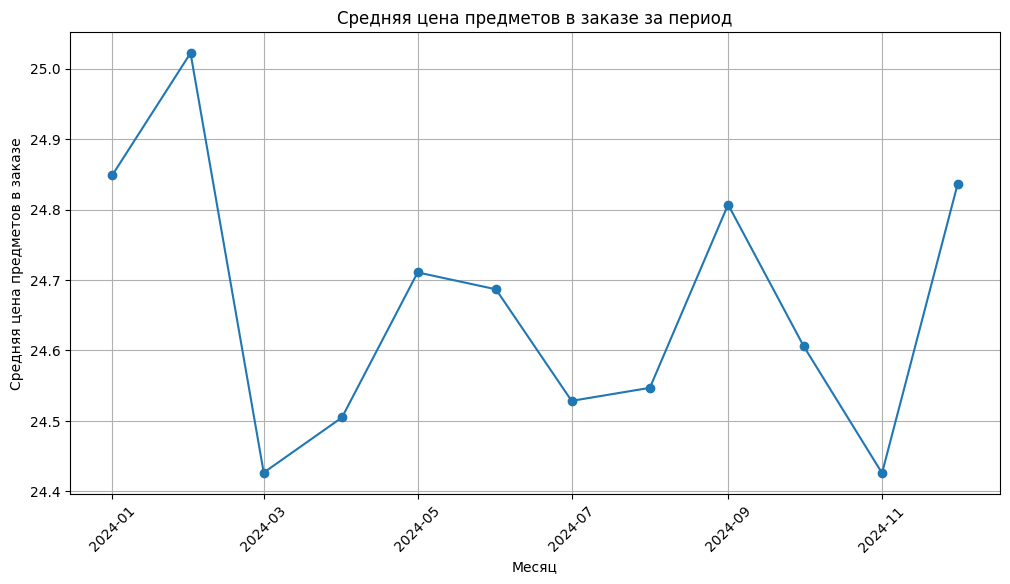

In [10]:
success_transactions = transactions.loc[transactions['status'] =='success'].copy()
success_transactions['month'] = pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp()
grouped_transactions =success_transactions.groupby('month').agg(
   price_sum=('price' , 'sum'),
   item_quantity=('transaction_id', 'count')
).reset_index()

grouped_transactions['avg_item_price'] = grouped_transactions['price_sum']/grouped_transactions['item_quantity']

plt.figure(figsize=(12,6))
plt.plot(grouped_transactions['month'], grouped_transactions['avg_item_price'], marker = 'o')
plt.title('Средняя цена предметов в заказе за период')
plt.xlabel('Месяц')
plt.ylabel('Средняя цена предметов в заказе')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Интерпретация графика:**
Средняя цена предметов в заказе не имеет критически низкого значения 2024-07 или в другие летние месяцы, когда произошел редизайн внутриигрового магазина. Эта метрика снижается в период с сентября по ноябрь, но потом график снова растет в значении средней цены предметов в заказе к декабрю. Эта метрика не оказала существенное влияние на изменение Выручки после летних изменений в игре. 


Выполним расчёт и визуализацию метрики **Среднее количество предметов в заказе за период**.
Формула для расчёта:
`Среднее количество предметов в заказе за период = Общее количество предметов, которые были в заказах за период / Количество заказов за период`
Количество заказов за период определяется как количество уникальных значений поля `transaction_id`.

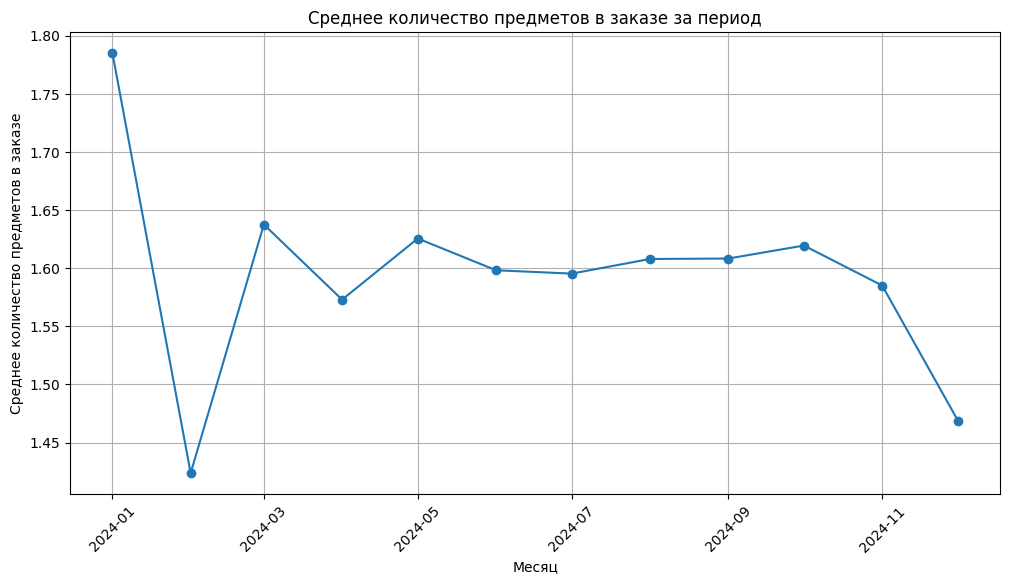

In [11]:
success_transactions = transactions.loc[transactions['status'] =='success'].copy()
success_transactions['month'] = pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp()
grouped_transactions =success_transactions.groupby('month').agg(
   order_quantity=('transaction_id', 'nunique'),
   item_quantity=('transaction_id', 'count')
).reset_index()

grouped_transactions['avg_item_count'] = grouped_transactions['item_quantity']/grouped_transactions['order_quantity']

plt.figure(figsize=(12,6))
plt.plot(grouped_transactions['month'], grouped_transactions['avg_item_count'], marker = 'o')
plt.title('Среднее количество предметов в заказе за период')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество предметов в заказе')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()




**Интерпретация графика:**
Среднее количество предметов в заказе не имеет критически низкого значения 2024-07 или в другие летние месяцы, когда произошел редизайн внутриигрового магазина. Эта метрика вряд ли оказала влияние на вышестоящие метрики, в том числе и выручку в целом. График имеет колебания, с середины года стабилизируется, пиковое значение было в январе.  Вероятно, метрика показывает такой результат ввиду того, что новые когорты показывают удержания хуже и это “запоздалый” эффект из за снижения RR. Данная метрика напрямую не объясняет снижение Выручки после начала лета. 


Рассчитаем средний чек с группировкой по месяцам. 
Для расчёта нам понадобятся результаты предыдущих заданий: 
`Средний чек = Средняя цена предметов в заказе за период × Среднее количество предметов в заказе за период`

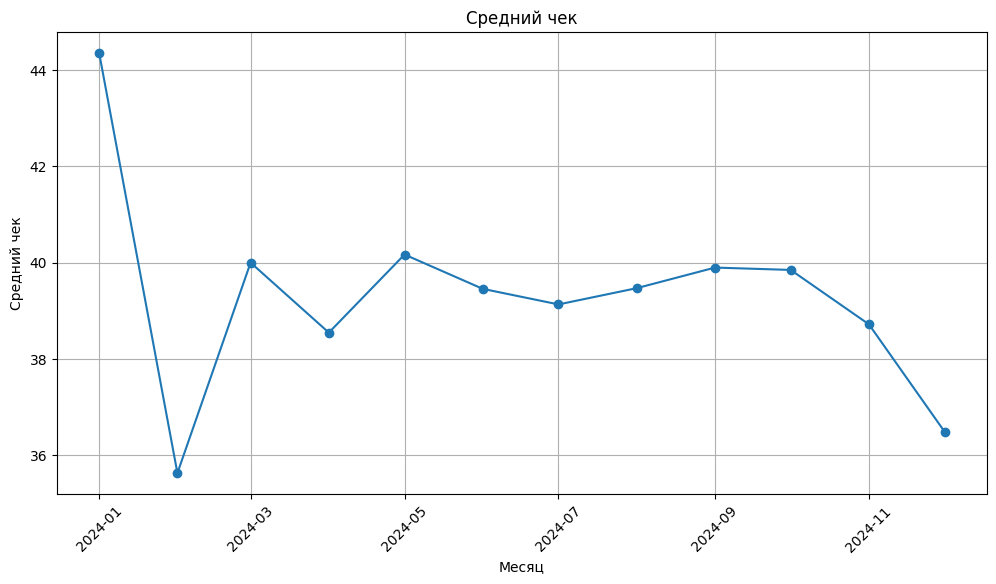

In [12]:
success_transactions = transactions.loc[transactions['status'] =='success'].copy()
success_transactions['month'] = pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp()

grouped_transactions = success_transactions.groupby('month').agg(
    order_quantity=('transaction_id', 'nunique'),
    item_quantity=('transaction_id', 'count'),
    price_sum=('price' , 'sum')
).reset_index()

grouped_transactions['avg_item_count'] = grouped_transactions['item_quantity']/grouped_transactions['order_quantity']
grouped_transactions['avg_item_price'] = grouped_transactions['price_sum']/grouped_transactions['item_quantity']
grouped_transactions['AOV'] = grouped_transactions['avg_item_count']*grouped_transactions['avg_item_price']

plt.figure(figsize=(12,6))
plt.plot(grouped_transactions['month'], grouped_transactions['AOV'], marker = 'o')
plt.title('Средний чек')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()




**Интерпретация графика:**
Средний чек не имеет критически низкого значения 2024-07 или в другие летние месяцы, когда произошел редизайн внутриигрового магазина. Эта метрика не оказала влияние на вышестоящие метрики, в том числе и выручку в целом. В целом график имеет колебания, с середины года стабилизируется, пиковое значение было в январе.  Самое низкое значение было в феврале.  Хочется отметить, что с ноября по декабрь значение снизилось. Очевидно, что существенное влияние на вид графика оказала метрика количество товаров в заказе, так как графики очень схожи между собой и выводы аналогичны. 

Выполним расчёт и визуализацию метрики доли пользователей, у которых пройдено более 10 уровней. Сгруппируем данные по месяцам. 
Формула метрики:
`Доля пользователей, у которых пройдено более 10 уровней = Количество пользователей, у которых последний успешно пройденный уровень > 10 по состоянию на период N / Количество пользователей, которые устанавливали приложение по состоянию на период N`

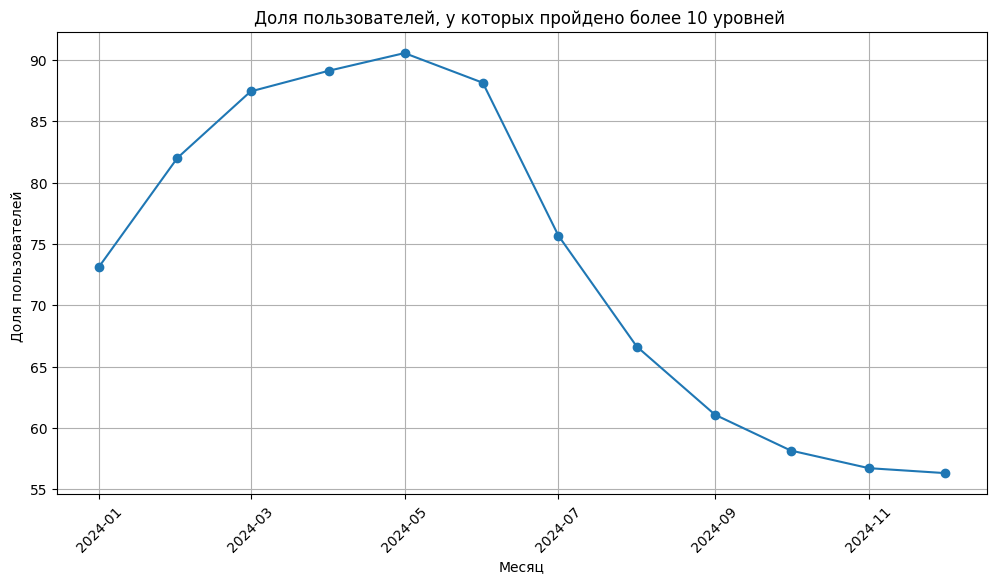

In [13]:
game_sessions['month'] = pd.to_datetime(game_sessions['time_end']).dt.to_period('M').dt.to_timestamp()
users['month'] = pd.to_datetime(users['install_time']).dt.to_period('M').dt.to_timestamp()

df_levels = game_sessions[(game_sessions['level_id'] == 11)&(game_sessions['success_fact']==1)]
df_levels_grouped = df_levels.groupby('month')['device_id'].nunique().reset_index()
df_levels_grouped['cumsum_users_level_success'] = df_levels_grouped['device_id'].cumsum()

df_users_grouped = users.groupby('month')['device_id'].nunique().reset_index()
df_users_grouped['cumsum_users_all'] = df_users_grouped['device_id'].cumsum()

table_final = pd.merge(df_levels_grouped, df_users_grouped, how = 'left', on = 'month')
table_final['levels_finish_rate'] = round(100 * (table_final['cumsum_users_level_success']/table_final['cumsum_users_all'] ), 2)

plt.figure(figsize=(12,6))
plt.plot(table_final['month'], table_final['levels_finish_rate'], marker = 'o')
plt.title('Доля пользователей, у которых пройдено более 10 уровней ')
plt.xlabel('Месяц')
plt.ylabel('Доля пользователей ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Интерпретация графика:**
Доля пользователей, у которых пройдено больше 10 уровней снижается к концу года,график имеет нисходящий тренд. С июля начинается спад графика, а самая высокая доля пользователей приходится на май. Эта ветка метрик однозначно повлияла на Среднюю выручку на активного пользователя, затем и на саму Выручку.


## Вывод

Выделим ключевые выводы, полученные из графиков выше, и определим, с чем может быть связано снижение ключевой метрики.

Ответим на вопросы: 

**Что произошло в продукте?**
Были замечены проблемы в летнее время, когда произошли изменения в пользовательском опыте: редизайн внутриигрового магазина и корректировка алгоритма, который генерирует уровни. Что-то из этих двух факторов, а может и оба, стало причиной снижения выручки. По итогам анализа мы пришли к выводу, что на снижение Выручки повлияла корректировка алгоритма, который генерирует уровни, так как метрики, связанные с прохождением уровней, показывали существенный спад в летнее время и далее. Проблемы, связанные с метрики по магазину возникли после начала лета и были не такими существенными. Далее распишем выводы по каждой метрике.

**В какой части продукта или в каких метриках это произошло?**
- Общий MAU и MAU по платформам - графики имеют восходящий тренд, спадов не наблюдается, все в порядке с данными метриками. 
- Новые пользователи по источникам привлечения - критических изменений не наблюдается. Графики в целом похожи и стабильны на протяжении периода. Можно потом изучить, почему канал organic работает лучше, чем остальные.
- Retention Rate - сильное ухудшение RR начинается с 2024-07-01, в тот момент, когда начались изменения в игре. Очевидно, эта ветка метрик повлияла на Выручку. 
- Средняя доля пройденных уровней на сессию - закономерно (так как мы выясняли, что RR имеет ухудшение), что метрика имеет нисходящий тренд, начиная с 2024-07-01, в тот момент, когда начались изменения в игре. Эта ветка повлияла на спад Выручки. Причиной этому служит изменение алгоритмов генерации уровней, вероятно, они стали слишком сложными и пользователям стало сложнее их проходить и они стали покидать игру.
- Средний доход с активного пользователя (ARPAU) - начиная с начала лета имеет нисходящий тренд. Очевидно, что эта метрика повлияла на спад Выручки.
- Динамика конверсии воронки - тут мы видим, что с каждым шагом конверсия уменьшается, на последнем шаге завершения покупки заметно, что в летнее время график прерывается.
- Доля пользователей, у которых пройдено более 10 уровней - график имеет нисходящий тренд. , начиная с 2024-07-01. Эта ветка повлияла на спад Выручки. Причиной этому служит изменение алгоритмов генерации уровней, вероятно, они стали слишком сложными и пользователям стало сложнее их проходить и они стали покидать игру. Поэтому мало пользователей проходит более 10 уровней.
- Средняя цена предметов в заказе - график имеет скачки и нет тенденции к спаду или росту на протяжении нескольких месяцев после изменений в игре, к концу года метрика даже растет. Она не повлияла на вышестоящие метрики и Выручку. 
- Среднее количество предметов в заказе - в начале года пик, далее резкий спад и к лету график стабилизируется, к концу года плавный спад. Изменение скорее всего связано с изменением редизайна внутриигрового магазина, но влияние на Выручку слабое и позднее, изменение алгоритмов генерации уровней влияет сильнее на метрики и, соответственно, Выручку, чем изменение дизайна магазина. 
- Средний чек - график схож с графиком Среднего количества предметов в заказе и выводы по нему аналогичны. 

**По какой причине это произошло? Что повлияло?**
Если судить по всем графикам, то метрики, связанные с удержанием пользователем, прохождением уровней начинали уменьшаться с начала лета и до конца года (более резко, чем метрики, связанные внутриигровым магазином ), поэтому можно предположить, что изменение алгоритмов генерации уровней влияет на метрики и, соответственно, Выручку. Компании стоит пересмотреть алгоритмы по генерации уровней в первую очередь, так как большая доля клиентов теряется из-за таких изменений. 